<a href="https://colab.research.google.com/github/yfhkucing/experiment_bms/blob/master/Heatmap_with_model_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import joblib
import numpy as np
import pandas as pd

In [43]:
! unzip /content/models_temp_30.zip

Archive:  /content/models_temp_30.zip
replace content/models/model 26? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/models/model 26  
  inflating: content/models/model 19  
  inflating: content/models/model 24  
  inflating: content/models/model 16  
  inflating: content/models/model 9  
  inflating: content/models/model 21  
  inflating: content/models/model 13  
  inflating: content/models/model 4  
  inflating: content/models/model 0  
  inflating: content/models/model 10  
  inflating: content/models/model 27  
  inflating: content/models/model 7  
  inflating: content/models/model 14  
  inflating: content/models/model 1  
  inflating: content/models/model 2  
  inflating: content/models/model 18  
  inflating: content/models/model 15  
  inflating: content/models/model 8  
  inflating: content/models/model 12  
  inflating: content/models/model 25  
  inflating: content/models/model 6  
  inflating: content/models/model 22  
  inflating: content/models/model 3  
 

In [44]:
feature = pd.read_excel('/content/Koordinat dan Input Skenario.xlsx',sheet_name='InputSkenario')
label = pd.read_excel('/content/data_big_4.xlsx',sheet_name='Sheet2')
feature.pop('Jam')
feature.pop('Fan')

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
187    1.0
188    1.0
189    1.0
190    1.0
191    1.0
Name: Fan, Length: 192, dtype: float64

In [45]:
def norm(df):
  df=(df-df.min())/(df.max()-df.min())
  return df

In [66]:
feature = norm(feature)
label = norm(label)

In [47]:
array_y = []

for i in range(30):
  frame= label[i::30]
  frame = frame.drop(['koor_x','koor_y'],axis=1)
  frame = frame.drop(['Vx','Vy'],axis=1)
  array_y.append(frame)

In [48]:
len(array_y)

30

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

skor_r2=[]
mae_=[]
rmse = []
y_predict = []
y_test = []
for i in range(30):
  x = np.array(feature)
  y = np.array(array_y[i])
  model = joblib.load(f'/content/content/models/model {i}')
  y_pred = model.predict(x)
  Skor_r2 = r2(y,y_pred)
  RMSE = mse(y,y_pred,squared=False)
  MAE = mae(y,y_pred)
  y_predict.append(y_pred)
  skor_r2.append(Skor_r2)
  mae_.append(MAE)
  rmse.append(RMSE)

In [50]:
skor_r2 = np.array(skor_r2)
rmse = np.array(rmse)
mae_=np.array(mae_)
y_predict = np.array(y_predict)
y = np.array(array_y)

In [51]:
#error per skenario

r_squared = []
abs_error = []
sqrt_error = []
for i in range(192):
  a = y[...,i,0]
  b = y_predict[...,i]
  r_squared.append(r2(a,b))
  abs_error.append(mae(a,b))
  sqrt_error.append(mse(a,b))

In [52]:
error = pd.DataFrame(r_squared,columns=['r2'])
abs_error = pd.DataFrame(abs_error,columns=['mae'])
sqrt_error = pd.DataFrame(sqrt_error,columns=['rmse'])
error = error.join(abs_error)
error = error.join(sqrt_error)

In [53]:
y_predict[...,191] == y_predict[...,0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [54]:
error.describe()

,r2,mae,rmse
count,192.000000,192.000000,192.000000
mean,-248.665328,24.967817,633.144946
std,379.795378,2.339685,122.134616
min,-3715.593455,20.428914,417.400470
25%,-234.991326,23.203825,540.350285
50%,-159.672788,24.231011,589.467691
75%,-105.388436,26.592161,715.071965
max,-39.008665,30.552896,947.274039


In [55]:
error[error.r2 == error.r2.max()]

,r2,mae,rmse
158,-39.008665,26.165326,701.313379


In [56]:
error[error.r2 == error.r2.min()]

,r2,mae,rmse
57,-3715.593455,20.428914,417.40047


In [57]:
r2_matrix = skor_r2.reshape(5,6)
rmse_matrix = rmse.reshape(5,6)
mae_matrix = mae_.reshape(5,6)

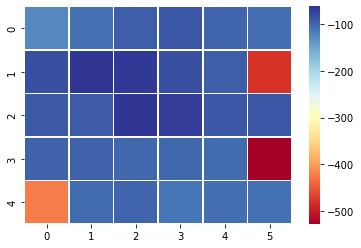

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(r2_matrix, linewidth=0.5, cmap="RdYlBu")
plt.show()

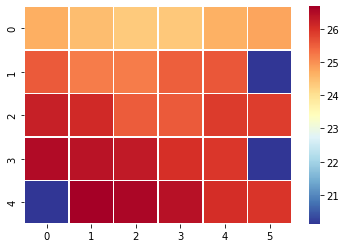

In [59]:
bx = sns.heatmap(rmse_matrix, linewidth=0.5, cmap="RdYlBu_r")
plt.show()

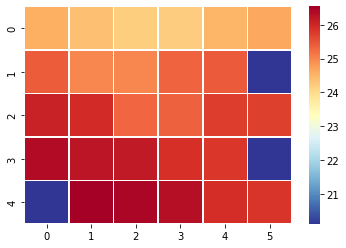

In [60]:
bx = sns.heatmap(mae_matrix, linewidth=0.5, cmap="RdYlBu_r")
plt.show()

In [61]:
! mkdir subplot

mkdir: cannot create directory ‘subplot’: File exists


In [62]:
df_koor = pd.read_excel('koordinat_30.xlsx',sheet_name='Sheet2',header=None,names=['koor_x','koor_y'])

In [63]:
def suhu(y):
  df_y = pd.DataFrame(y)
  df_z = pd.DataFrame(y)
  df_z.rename(columns={0:1},inplace=True)
  df_y = df_y.join(df_z)
  df_y = df_y.join(df_koor)
  df_y.rename(columns={0:'Vx',1:'suhu'},inplace=True)
  df_y.pop('Vx')
  return df_y

In [64]:
from plotly.subplots import make_subplots
for i in range(192):
  a = y[(...,i,0)]
  b = y_predict[(...,i)]
  a = np.array(a)
  b = np.array(b)
  a = suhu(a)
  b = suhu(b)
  
  fig = make_subplots(rows=1, cols=2)

  fig.add_contour(
     z = a['suhu'].tolist(),
     x = a['koor_x'].tolist(),
     y = a['koor_y'].tolist(),
     row=1, col=1
  )

  fig.add_contour(
     z = b['suhu'].tolist(),
     x = b['koor_x'].tolist(),
     y = b['koor_y'].tolist(),
     row=1, col=2
  )
  fig.write_image(f'/content/subplot/fig {i}.png')

In [65]:
!zip -r /content/subplot.zip /content/subplot

updating: content/subplot/ (stored 0%)
updating: content/subplot/fig 39.png (deflated 4%)
updating: content/subplot/fig 104.png (deflated 5%)
updating: content/subplot/fig 172.png (deflated 4%)
updating: content/subplot/fig 146.png (deflated 4%)
updating: content/subplot/fig 153.png (deflated 5%)
updating: content/subplot/fig 70.png (deflated 4%)
updating: content/subplot/fig 32.png (deflated 3%)
updating: content/subplot/fig 180.png (deflated 4%)
updating: content/subplot/fig 84.png (deflated 4%)
updating: content/subplot/fig 93.png (deflated 4%)
updating: content/subplot/fig 189.png (deflated 5%)
updating: content/subplot/fig 0.png (deflated 4%)
updating: content/subplot/fig 125.png (deflated 5%)
updating: content/subplot/fig 3.png (deflated 4%)
updating: content/subplot/fig 137.png (deflated 4%)
updating: content/subplot/fig 144.png (deflated 5%)
updating: content/subplot/fig 67.png (deflated 4%)
updating: content/subplot/fig 129.png (deflated 5%)
updating: content/subplot/fig 135.p